In [1]:
import os
import math
import json
import random
import h5py
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Read in data

In [2]:
data = pd.read_csv('data/gap_filling_station_info.csv', parse_dates=['date'])

with open('data/measurement_sites.json', 'r') as file:
    measurement_sites = pd.read_json(file)

stations = ['ABZ', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'EGB', 'FKL', 'HAD', 
            'HEL', 'HPB', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 'MUK',
            'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'PRL',
            'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

# select stations
data = data[data.station.isin(stations)]

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude', 'altitude']

env_types = ['env_type_urban', 'env_type_urban_background', 'env_type_rural', 'env_type_rural_background', 'env_type_remote']

feature_list = gases + met + aerosols + loc + env_types

for station in stations:
    if station in measurement_sites:
        data.loc[data.station == station, 'latitude'] = measurement_sites[station]['latitude']
        data.loc[data.station == station, 'longitude'] = measurement_sites[station]['longitude']
        data.loc[data.station == station, 'altitude'] = measurement_sites[station]['altitude']

data['lat_original'] = data['latitude'].copy()
data['long_original'] = data['longitude'].copy()  

# min-max normalize static reals
for column in loc:
    min_val = data[column].min()
    max_val = data[column].max()
    data[column] = (data[column] - min_val) / (max_val - min_val)

log_transform = aerosols + gases + met

# log-transforming time-varying reals
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    

n100_positive_min = data['n100'][data['n100'] > 0].min()
data['n100'] = data['n100'].apply(lambda x: np.log(n100_positive_min) if (x < 0) else x)
data['n100'] = data['n100'].apply(lambda x: np.log(x) if pd.notnull(x) else np.nan)

data.rename(columns={'n100': 'target'}, inplace=True)

data.head()

,id,station,date,latitude,longitude,target,aermr01,aermr02,aermr03,aermr04,...,wind_speed,altitude,environment_type,env_type_remote,env_type_rural,env_type_rural_background,env_type_urban,env_type_urban_background,lat_original,long_original
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,0.816071,0.510582,8.004610,-25.205400,-20.758221,-23.644620,-32.349837,...,0.851615,0.23705,urban_background,0,0,0,0,1,50.57,12.99
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,0.816071,0.510582,7.930467,-25.128177,-20.680886,-23.922713,-33.939763,...,0.828870,0.23705,urban_background,0,0,0,0,1,50.57,12.99
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,0.816071,0.510582,7.648740,-25.586803,-21.139579,-24.793668,-30.044488,...,0.659509,0.23705,urban_background,0,0,0,0,1,50.57,12.99
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,0.816071,0.510582,7.493512,-26.083640,-21.636795,-25.519402,-28.561505,...,0.463058,0.23705,urban_background,0,0,0,0,1,50.57,12.99
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,0.816071,0.510582,7.599552,-26.317107,-21.870332,-26.070951,-27.517164,...,0.544678,0.23705,urban_background,0,0,0,0,1,50.57,12.99


## Create segments

In [3]:
# Drop NaNs
data = data.dropna(axis=0)

# Compute the difference between consecutive rows
differences = data['target'].diff()

# Filter out rows where the difference is zero
data = data[differences != 0]

In [4]:
# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# find rows where time difference is greater than 3 hours
gap_rows = time_diff > pd.Timedelta('3 hours')

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(data['station']).cumsum()

# create group_ids column by concatenating station name and segment_ids
data['group_ids'] = data['station'] + '_segment_' + segment_ids.astype(str)

# group by station and group_ids, and assign a unique index to each row within each group
data['time_idx'] = data.groupby(['station', 'group_ids']).cumcount()

In [5]:
data.head()

,id,station,date,latitude,longitude,target,aermr01,aermr02,aermr03,aermr04,...,environment_type,env_type_remote,env_type_rural,env_type_rural_background,env_type_urban,env_type_urban_background,lat_original,long_original,group_ids,time_idx
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,0.816071,0.510582,8.004610,-25.205400,-20.758221,-23.644620,-32.349837,...,urban_background,0,0,0,0,1,50.57,12.99,ABZ_segment_0,0
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,0.816071,0.510582,7.930467,-25.128177,-20.680886,-23.922713,-33.939763,...,urban_background,0,0,0,0,1,50.57,12.99,ABZ_segment_0,1
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,0.816071,0.510582,7.648740,-25.586803,-21.139579,-24.793668,-30.044488,...,urban_background,0,0,0,0,1,50.57,12.99,ABZ_segment_0,2
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,0.816071,0.510582,7.493512,-26.083640,-21.636795,-25.519402,-28.561505,...,urban_background,0,0,0,0,1,50.57,12.99,ABZ_segment_0,3
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,0.816071,0.510582,7.599552,-26.317107,-21.870332,-26.070951,-27.517164,...,urban_background,0,0,0,0,1,50.57,12.99,ABZ_segment_0,4


## Plot segment stats

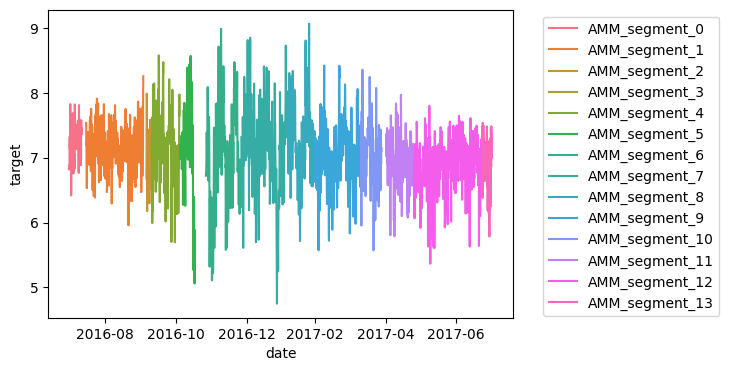

In [6]:
# Filter the data for station ZOT
filtered_data = data[data.station == 'AMM']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='target', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [7]:
# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta('3 hours')]

# group by station and group_ids, and calculate the length of each segment
segment_lengths = data.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

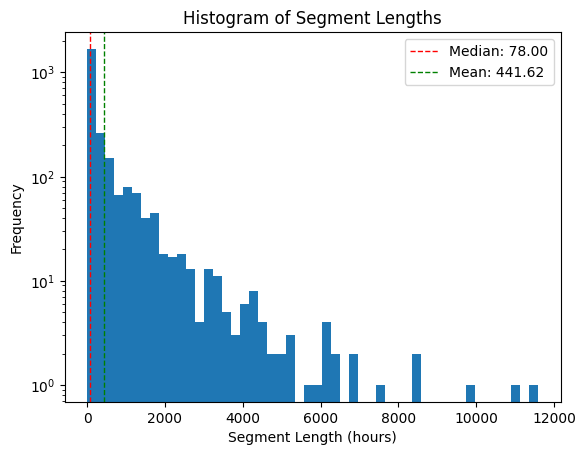

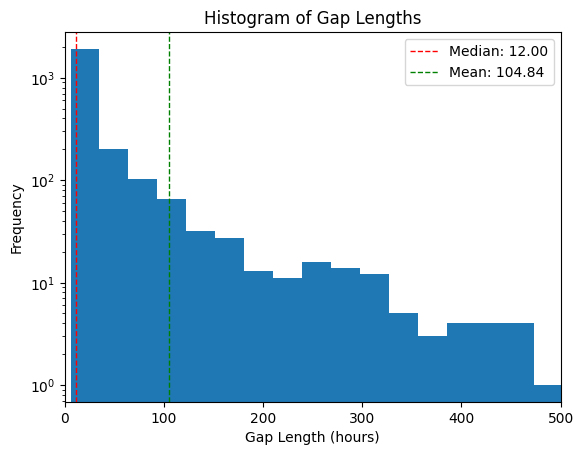

In [8]:
# calculate median, mean, and std for segment lengths
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean)])
plt.show()

# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean)])
plt.xlim([0, 500])
plt.show()

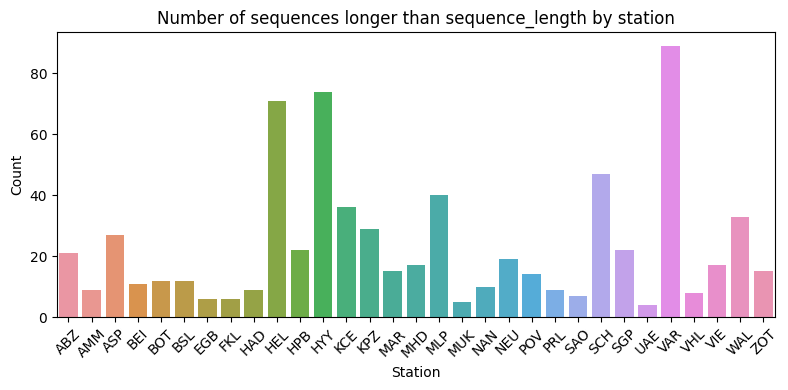

In [9]:
sequence_length = 112

stations = data['station'].unique()

counts = {}

for station in stations:
    station_data = data[data.station == station]
    unique_groups = station_data['group_ids'].unique()
    count = 0
    for group_id in unique_groups:
        group_data = station_data[station_data.group_ids == group_id]
        if len(group_data) >= sequence_length:
            count += 1
    counts[station] = count

df_counts = pd.DataFrame(list(counts.items()), columns=['Station', 'Count'])

plt.figure(figsize=(8, 4))
sns.barplot(x='Station', y='Count', data=df_counts)
plt.title('Number of sequences longer than sequence_length by station')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

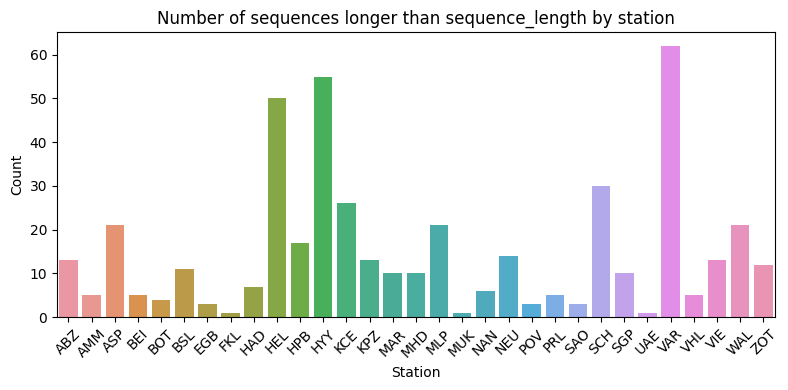

In [10]:
sequence_length = 224

stations = data['station'].unique()

counts = {}

for station in stations:
    station_data = data[data.station == station]
    unique_groups = station_data['group_ids'].unique()
    count = 0
    for group_id in unique_groups:
        group_data = station_data[station_data.group_ids == group_id]
        if len(group_data) >= sequence_length:
            count += 1
    counts[station] = count

df_counts = pd.DataFrame(list(counts.items()), columns=['Station', 'Count'])

plt.figure(figsize=(8, 4))
sns.barplot(x='Station', y='Count', data=df_counts)
plt.title('Number of sequences longer than sequence_length by station')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot station summary

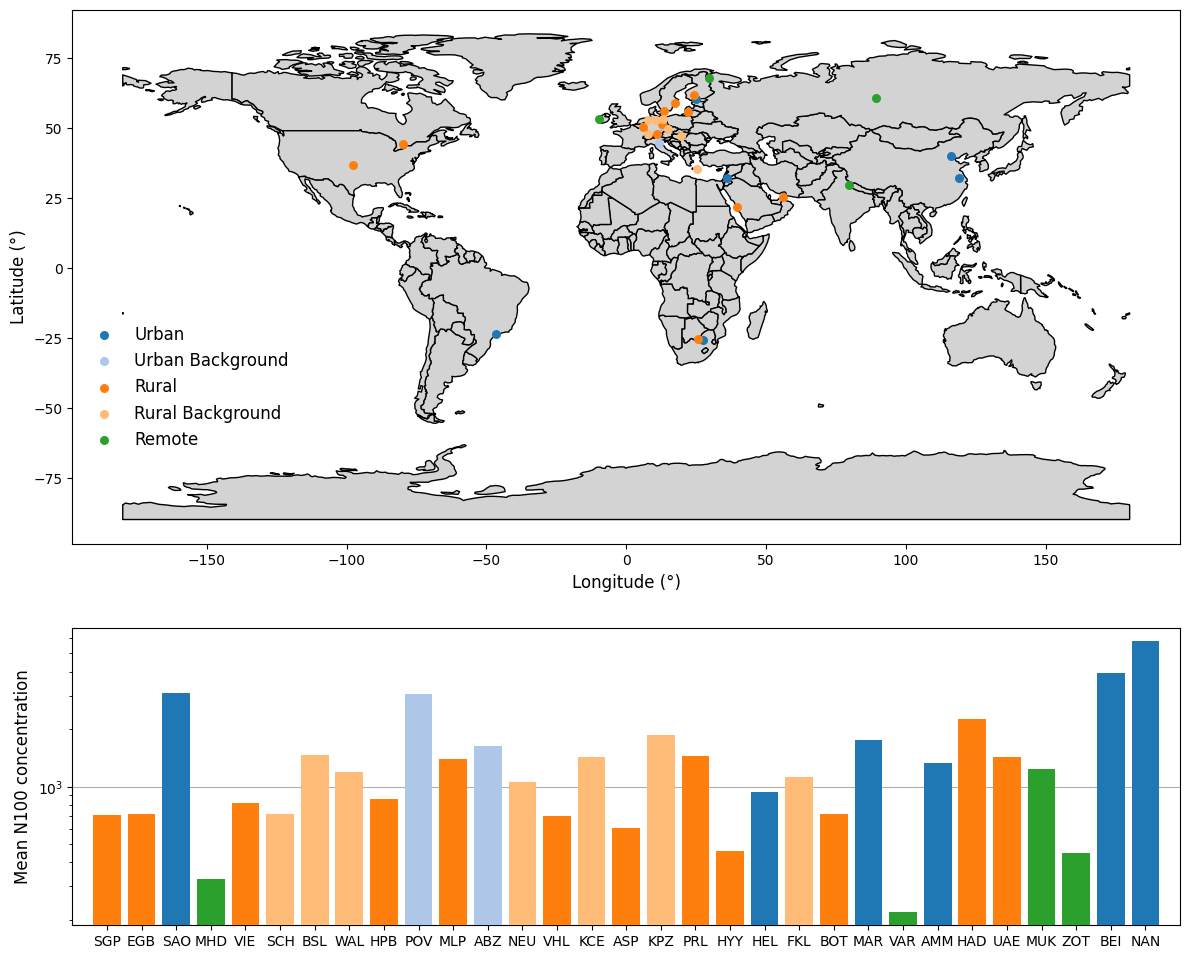

In [11]:
unique_stations = data.drop_duplicates(subset='station').copy()

def extract_labels(row):
    for env_type in env_types:
        if row[env_type]:
            return env_type.replace('env_type_', '').replace('_', ' ').title()
    return None

unique_stations['label'] = unique_stations.apply(extract_labels, axis=1)

gdf = gpd.GeoDataFrame(unique_stations, 
                       geometry=gpd.points_from_xy(unique_stations.long_original.unique(), unique_stations.lat_original.unique()),
                       crs='EPSG:4326') # WGS84 coordinate system

# Create subplots with 2 rows and adjust the height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot the world map and stations on ax1
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='lightgray', edgecolor='black')
labels = [env_type.replace('env_type_', '').replace('_', ' ').title() for env_type in env_types]

for label, color in zip(labels, plt.cm.tab20.colors):
    gdf[gdf['label'] == label].plot(ax=ax1, marker='o', label=label, color=color, markersize=30)

ax1.set_aspect(1.)
ax1.set_xlabel('Longitude (°)', fontsize=12)
ax1.set_ylabel('Latitude (°)', fontsize=12)
ax1.legend(loc='lower left', frameon=False, bbox_to_anchor=(0, 0.15), fontsize=12)

# Bar plot on ax2
ordered_stations = unique_stations.sort_values(by='longitude')['station'].tolist()
station_means = {}
for s in ordered_stations:
    group = data[data['station'] == s]
    station_means[s] = np.exp(group.target).mean()
    
station_colors = dict(zip(unique_stations['station'], unique_stations['label'].map(lambda label: dict(zip(labels, plt.cm.tab20.colors))[label])))

n100_means_ordered = [station_means[s] for s in ordered_stations]
bar_colors_ordered = [station_colors[s] for s in ordered_stations]

ax2.bar(ordered_stations, n100_means_ordered, color=bar_colors_ordered, zorder=3)
ax2.grid(axis='y')
ax2.set_ylabel('Mean N100 concentration', fontsize=12)
ax2.semilogy(base=10)
ax2.set_xlim(-1, len(ordered_stations))
plt.tight_layout()
plt.savefig('figures/stations.pdf')
plt.show()

## Create dataset for training

In [12]:
pd.options.mode.chained_assignment = None

chosen_seq = 'four_weeks'

def create_gaps(seq, gap_size):
    start = np.random.randint(0, len(seq) - gap_size)
    end = start + gap_size
    mask = np.ones(len(seq), dtype=bool)
    mask[start:end] = False
    return mask

if chosen_seq == 'two_weeks':
    sequence_length = 112 # 2 weeks
    min_gap_size = 24 # 3 days
    max_gap_size = 56 # 1 week
    dir_name = 'data/two_week_seq'

if chosen_seq == 'four_weeks':
    sequence_length = 224 # 4 weeks
    min_gap_size = 56 # 7 days
    max_gap_size = 112 # 2 week
    dir_name = 'data/four_week_seq'

os.makedirs(dir_name)

# Loop over each unique group
for group_id in tqdm(data.group_ids.unique()):
    group_data = data[data.group_ids == group_id]
    
    # Exclude groups shorter than sequence_length
    if len(group_data) < sequence_length:
        continue

    # Create HDF5 file for the group
    with h5py.File(f'{dir_name}/{group_id}.hdf5', 'w') as h5file:
        # Use a sliding window to split the group data into sequences of length sequence_length
        for start in range(len(group_data) - sequence_length + 1):
            end = start + sequence_length
            split_data = group_data.iloc[start:end].copy()

            # Create gap
            gap_size = np.random.randint(low=min_gap_size, high=max_gap_size)
            split_data['mask'] = create_gaps(split_data['target'], gap_size)
            
            # Fill targets in the gap using the average value of targets outside the gap
            split_data['avg_target'] = split_data['target']
            outside_gap_data = split_data.loc[split_data['mask'], 'target']
            split_data.loc[~split_data['mask'], 'avg_target'] = outside_gap_data.mean()

            target_data = split_data[['date', 'avg_target', 'target', 'mask']]
            covariate_data = split_data[['date'] + feature_list]

            # Convert 'date' column to unix time (number of seconds since 1970-01-01 00:00:00)
            target_data['date'] = target_data['date'].map(pd.Timestamp.timestamp)
            covariate_data['date'] = covariate_data['date'].map(pd.Timestamp.timestamp)

            # Convert booleans to int
            target_data = target_data.astype({'mask': 'int'})

            # Appending with pandas hdf is very slow
            # target_data.to_hdf(f'{dir_name}/{group_id}.hdf5', key=f'observations_{start}', mode='a')
            # covariate_data.to_hdf(f'{dir_name}/{group_id}.hdf5', key=f'covariates_{start}', mode='a')

            # Save the split data to the HDF5 file
            h5file.create_dataset(f'{start}/target', data=target_data)
            h5file.create_dataset(f'{start}/covariates', data=covariate_data)

  0%|          | 0/2533 [00:00<?, ?it/s]

In [13]:
covariate_data.head()

,date,co,c5h8,c10h16,nh3,no,no2,so2,d2m,t2m,...,aermr10,aermr11,latitude,longitude,altitude,env_type_urban,env_type_urban_background,env_type_rural,env_type_rural_background,env_type_remote
476801,1.257206e+09,-15.963662,-23.963432,-23.614892,-25.684202,-27.705152,-20.956123,-22.282063,5.588929,5.598584,...,-38.187575,-34.597640,0.92553,0.863447,0.0518,0,0,0,0,1
476802,1.257217e+09,-15.967827,-23.727521,-23.357204,-25.818660,-23.925861,-21.280509,-22.575695,5.588525,5.597681,...,-38.187575,-34.597640,0.92553,0.863447,0.0518,0,0,0,0,1
476803,1.257228e+09,-15.966522,-23.771570,-23.131190,-25.919477,-23.477779,-21.639955,-22.746638,5.587659,5.597856,...,-29.111525,-28.706060,0.92553,0.863447,0.0518,0,0,0,0,1
476804,1.257239e+09,-15.961372,-23.644915,-22.934387,-25.763396,-24.313080,-21.638957,-22.880397,5.588720,5.597424,...,-25.863354,-25.595002,0.92553,0.863447,0.0518,0,0,0,0,1
476805,1.257250e+09,-15.964753,-23.526391,-23.032625,-25.740278,-27.514389,-21.574375,-22.910314,5.588661,5.597631,...,-25.211488,-24.141060,0.92553,0.863447,0.0518,0,0,0,0,1


In [14]:
target_data.head()

,date,avg_target,target,mask
476801,1.257206e+09,5.768425,5.768425,1
476802,1.257217e+09,5.801514,5.801514,1
476803,1.257228e+09,5.794638,5.794638,1
476804,1.257239e+09,5.555798,5.555798,1
476805,1.257250e+09,5.352016,5.352016,1


In [15]:
data_splits = [0.8, 0.1, 0.1]

# Group files by station
files_by_station = defaultdict(list)
for f in os.scandir(dir_name):
    if f.is_file() and f.name.endswith('.hdf5'):
        station = f.name.split('_')[0]
        files_by_station[station].append(f.path)

# Shuffle the files within each station and split according to data_splits
train_files = []
val_files = []
test_files = []
random.seed(42)
for station, files in files_by_station.items():
    random.shuffle(files)
    train_ratio, val_ratio = data_splits[:2]
    train_split = int(train_ratio * len(files))
    val_split = train_split + int(val_ratio * len(files))
    train_files.extend(files[:train_split])
    val_files.extend(files[train_split:val_split])
    test_files.extend(files[val_split:])

In [16]:
def get_data_paths(flist):
    ds = []
    for f in tqdm(flist):
        with h5py.File(f, 'r') as h5file:
            for key in h5file.keys():
                ds.append((f, key))
    return ds

train_paths = get_data_paths(train_files)
val_paths = get_data_paths(val_files)
test_paths = get_data_paths(test_files)

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
metadata = {
    # 'scaler_params': scaler_params,
    'train': train_paths,
    'val': val_paths,
    'test': test_paths
}

with open(os.path.join(dir_name, 'paths.json'), 'w') as f:
    json.dump(metadata, f, indent=2)